## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

### 1. Understand the data

In [171]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [91]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [92]:
# check the NaN value
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [93]:
# check the duplicate data 
train_data.duplicated().sum()

0

In [94]:
# check the buying rate with & without the promotion 
Buying_rate = train_data.groupby('Promotion')['purchase'].mean()
print('Without Promotion, the buying rate is: ', Buying_rate[0])
print('With Promotion, the buying rate is: ', Buying_rate[1])

Without Promotion, the buying rate is:  0.007564619397676073
With Promotion, the buying rate is:  0.017019167217448776


In [95]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [96]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


### 2. Calculating the key parameters

In [97]:
#calculate the IRR value
def irr_cal(df):
    '''
    calculate the IRR rate
    '''
    cust_treat = df.query('Promotion == "Yes"').shape[0]
    cust_ctrl = df.query('Promotion == "No"').shape[0]
    purch_treat = df.query('Promotion == "Yes" and purchase == 1').shape[0]
    purch_ctrl = df.query('Promotion == "No" and purchase == 1').shape[0]
    
    IRR = purch_treat/cust_treat - purch_ctrl/cust_ctrl
    return IRR

print("The IRR value of the training data is: {:.2%}.".format(irr_cal(train_data)))

The IRR value of the training data is: 0.95%.


In [98]:
#calculate the NIR value
def nir_cal(df):
    '''
    calculate the NIR rate
    '''
    cust_treat = df.query('Promotion == "Yes"').shape[0]
    cust_ctrl = df.query('Promotion == "No"').shape[0]
    purch_treat = df.query('Promotion == "Yes" and purchase == 1').shape[0]
    purch_ctrl = df.query('Promotion == "No" and purchase == 1').shape[0]
    
    NIR = 10 * purch_treat - 0.15 * cust_treat - 10 * purch_ctrl
    return NIR
print("The NIR value of the training data is: ${:.2f}.".format(nir_cal(train_data)))

The NIR value of the training data is: $-2334.60.


### 3. Understanding the statistical significance  

In [99]:
#check the sampling difference between control & treat group
train_data.groupby('Promotion').size()

Promotion
No     42170
Yes    42364
dtype: int64

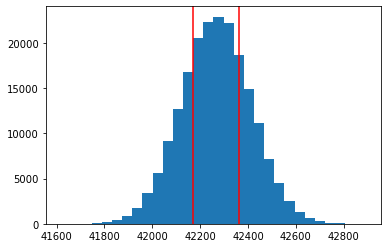

In [100]:
# We assume the null hypothesis is: "the possibility to give promotion is 0.5"
# simulate the outcomes under null, compared to observed outcome
n_obs = train_data.shape[0]
n_control = train_data.groupby('Promotion').size()[0]
n_treat = train_data.groupby('Promotion').size()[1]
p = 0.5
n_trails = 200000
samples = np.random.binomial(n_obs, p, n_trails)
plt.hist(samples, bins = 30)
plt.axvline(x = n_control, c = 'red')
plt.axvline(x = n_obs - n_control, c = 'red')

In [101]:
# calculate the p-value
(samples < n_control).mean() + (samples > n_treat).mean()

0.503155

Thus, it can be concluded that the null hypothesis could not be given up

### 4. Understanding the evaluation matric

In [102]:
#calculate the averaging purchasing rate
train_data['purchase'].mean()

0.012302742091939338

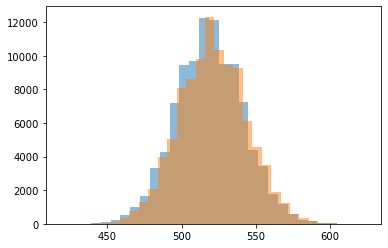

In [103]:
# We assume the null hypothesis is: "there is no difference in control & treat"
# simulate the outcomes under null, compared to observed outcome
n_control = train_data.groupby('Promotion').size()[0]
n_treat = train_data.groupby('Promotion').size()[1]
p = train_data['purchase'].mean()
n_trails = 100000

ctrl_buy = np.random.binomial(n_control, p, n_trails)
treat_buy = np.random.binomial(n_treat, p, n_trails)
plt.hist(ctrl_buy, bins = 30, alpha = 0.5);
plt.hist(treat_buy, bins = 30, alpha = 0.5);


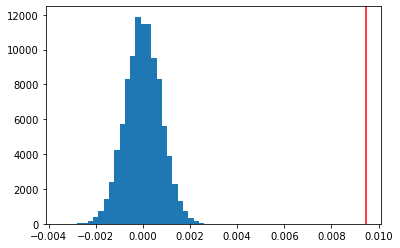

In [104]:
samples = ctrl_buy/n_control - treat_buy/n_treat
plt.hist(samples, bins = 30)
plt.axvline(irr_cal(train_data), c = 'red')

In [105]:
#calculate the p value 
(samples > irr_cal(train_data)).mean()

0.0

It can be concluded that there is a very obvious difference in the purchasing rate between the control group and the treat(experimental) group, so that the null assumption should be given up.

### 5. Logistic regression

In [106]:
#data preparation slightly more, all the datatype will transferd to be variable 
train_data[['promote_no','promote_yes']] = \
pd.get_dummies(train_data['Promotion'])
train_data = train_data.drop('Promotion', axis = 1)
train_data.head(5)

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,promote_no,promote_yes
0,1,0,2,30.443518,-1.165083,1,1,3,2,1,0
1,3,0,3,32.159350,-0.645617,2,3,2,2,1,0
2,4,0,2,30.431659,0.133583,1,1,4,2,1,0
3,5,0,0,26.588914,-0.212728,2,1,4,2,1,0
4,8,0,3,28.044332,-0.385883,1,1,2,2,0,1


In [107]:
log_mod = sm.Logit(train_data['purchase'], train_data[['V1','V2','V3','V4','V5','V6','V7','promote_no','promote_yes']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.064743
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.024     
Dependent Variable: purchase         AIC:              10963.9649
Date:               2020-08-30 22:41 BIC:              11048.0691
No. Observations:   84534            Log-Likelihood:   -5473.0   
Df Model:           8                LL-Null:          -5607.4   
Df Residuals:       84525            LLR p-value:      1.6937e-53
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
V1           -0.0539    0.0360   -1.4969  0.1344  -0.1245   0.0167
V2           -0.0031    0.0062   -0.4932  0.6219  -0.0153   0.0091
V3           -0.0614    0.0313   -1.9599  0.0500  -0.1227   0.0000
V4            0.7374    0.0802    9.1983  0.0000   0.5802   0.8945
V5            0.0854    0.0373    2.2929  0.0219   0.0124   0.1585
V6           -0.0131    0.0280   -0.4685  0.6394  -0.0680   0.0418
V7           -0.0194    0.0680   -0.2853  0.7754  -0.1527   0.1139
promote_no   -6.1349    0.2973  -20.6354  0.0000  -6.7176  -5.5522
promote_yes  -5.3110    0.2941  -18.0585  0.0000  -5.8875  -4.7346
=================================================================

"""

In [108]:
#load the test data
test_data = pd.read_csv('./test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [109]:
#modify the test data
test_data[['promote_no','promote_yes']] = \
pd.get_dummies(test_data['Promotion'])
test_data = test_data.drop('Promotion', axis = 1)
test_data.head(5)

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,promote_no,promote_yes
0,2,0,1,41.376390,1.172517,1,1,2,2,1,0
1,6,0,1,25.163598,0.653050,2,2,2,2,0,1
2,7,0,1,26.553778,-1.597972,2,3,4,2,0,1
3,10,0,2,28.529691,-1.078506,2,3,2,2,1,0
4,12,0,2,32.378538,0.479895,2,2,1,2,1,0


In [110]:
#predict the data 
test_data['predicted'] = results.predict(test_data[['V1','V2','V3','V4','V5','V6','V7','promote_no','promote_yes']])
test_data['predicted'] = test_data['predicted'].round().astype(int)
test_data[test_data['purchase']==1].head(5)

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,promote_no,promote_yes,predicted
391,1180,1,2,21.677294,0.306739,2,3,2,1,0,1,0
392,1185,1,1,25.879956,0.220161,2,2,2,1,0,1,0
457,1411,1,0,19.164378,-0.299306,2,1,3,2,0,1,0
688,2118,1,3,25.644523,-1.165083,2,4,3,2,0,1,0
794,2419,1,1,25.786070,-0.212728,2,4,4,1,0,1,0


In [111]:
confusion_matrix(test_data['purchase'],test_data['predicted'])

array([[41170,     0],
       [  480,     0]], dtype=int64)

It can be noticed that the logic regression is not very accurate, we may want to use the decision tree to better clarify this question 

### 6. Decision Tree Classifier 

In [112]:
#check the format of train_data and test_data
train_data.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,promote_no,promote_yes
0,1,0,2,30.443518,-1.165083,1,1,3,2,1,0
1,3,0,3,32.159350,-0.645617,2,3,2,2,1,0
2,4,0,2,30.431659,0.133583,1,1,4,2,1,0
3,5,0,0,26.588914,-0.212728,2,1,4,2,1,0
4,8,0,3,28.044332,-0.385883,1,1,2,2,0,1


In [113]:
#check the format of train_data and test_data
test_data.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,promote_no,promote_yes,predicted
0,2,0,1,41.376390,1.172517,1,1,2,2,1,0,0
1,6,0,1,25.163598,0.653050,2,2,2,2,0,1,0
2,7,0,1,26.553778,-1.597972,2,3,4,2,0,1,0
3,10,0,2,28.529691,-1.078506,2,3,2,2,1,0,0
4,12,0,2,32.378538,0.479895,2,2,1,2,1,0,0


In [196]:
#define the traning data set as well as the testing data set
X_train = train_data.iloc[:,2:9]
X_test = test_data.iloc[:,2:9]
y_train = train_data['purchase']
y_test = test_data['purchase']

In [197]:
#Do the Decision tree classifier
tree = DecisionTreeClassifier(random_state = 16, max_depth = 5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [198]:
#draw the confusion matrixs
confusion_matrix(y_test,y_pred)

array([[41167,     3],
       [  480,     0]], dtype=int64)

In [199]:
#check the accuracy 
accuracy_score(y_test,y_pred)

0.9884033613445378

It is observed that although the prediction accuracy is high, but the purchase prediction is still not high. actually, in order to achieve a very high, the decision tree prefer to predict all the cases that the customer won't purchase the goods. therefore, we may need to randomly delete most of the rows which has a purchase value of "0" and implement regression or decision again.


In [200]:
#Check the number of purchased & no-purchased cases
num_nopur = (y_train==0).sum()
num_pur = (y_train==1).sum()
print("In the training data set, {} customers bought the goods, {} customers did not buy the goods".format(num_pur, num_nopur))

In the training data set, 1040 customers bought the goods, 83494 customers did not buy the goods


In [201]:
# re-select and form the new training data-set 
in_nopur = y_train[y_train==0].index
in_pur = y_train[y_train==1].index 
in_nopur = np.random.choice(in_nopur, size = num_pur*2, replace = False)
indice = np.concatenate((in_pur,in_nopur))

In [202]:
X_train_new = X_train.iloc[indice]
y_train_new = y_train.iloc[indice]

In [203]:
newtree = DecisionTreeClassifier(random_state = 16, max_depth = 4, \
                                 min_samples_leaf = 7, min_samples_split = 20)
newtree.fit(X_train_new, y_train_new)
y_pred = newtree.predict(X_test)

In [204]:
confusion_matrix(y_test,y_pred)

array([[40821,   349],
       [  478,     2]], dtype=int64)

In [205]:
accuracy_score(y_test,y_pred)

0.9801440576230492

In [299]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = newtree.predict_proba(df)[:,1]

    yes = np.where(promotion > 0.3)
    no  = np.where(promotion <= 0.3)
    promotion= promotion.astype('str')
    promotion[yes] = 'Yes'
    promotion[no] = 'No'
    return promotion

In [300]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0179.

Your nir with this strategy is 305.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01786737542536707, 305.10000000000014)